### Agenda 
* Working with Nearest Neighbors
* Test-Based Distances
* Computing Mixed Distance Functions
* Nearest for Image Recognition


In [49]:
# import required libraries
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import tensorflow as tf
import requests
from tensorflow.python.framework import ops
ops.reset_default_graph()

In [50]:
sess = tf.Session()

In [51]:
housing_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data'

In [52]:
housing_header = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

* CRIM : per capita crime rate by town
* ZN : prop. of res. land zones
* INDUS : prop. of non-retail business acres
* CHAS : Charles river dummy variable
* NOX : nitrix oxides concentration / 10 M
* RM : Avg. # of rooms per building
* AGE : prop. of buildings built prior to 1940
* DIS : Weighted distances to employment centers
* RAD : Index of radian highway access
* TAX : Full tax rate value per $10k
* PTRATIO: Pupil/Teacher ratio by town
* B : 1000*(Bk-0.63)^2, Bk=prop. of blacks
* LSTAT : % lower status of pop

----y-data----
* MEDV : Median Value of homes 

In [53]:
cols_used = ['CRIM', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT']
num_features = len(cols_used)
housing_file = requests.get(housing_url)

housing_data = [[float(x) for x in y.split(' ') if len(x)>=1] for y in housing_file.text.split('\n') if len(y)>=1]

y_vals = np.transpose([np.array([y[13] for y in housing_data])])
x_vals = np.array([[x for i,x in enumerate(y) if housing_header[i] in cols_used] for y in housing_data])

## Min-Max Scaling
x_vals = (x_vals - x_vals.min(0)) / x_vals.ptp(0)

In [54]:
x_vals

array([[  0.00000000e+00,   6.78152493e-02,   3.14814815e-01, ...,
          2.87234043e-01,   1.00000000e+00,   8.96799117e-02],
       [  2.35922539e-04,   2.42302053e-01,   1.72839506e-01, ...,
          5.53191489e-01,   1.00000000e+00,   2.04470199e-01],
       [  2.35697744e-04,   2.42302053e-01,   1.72839506e-01, ...,
          5.53191489e-01,   9.89737254e-01,   6.34657837e-02],
       ..., 
       [  6.11892474e-04,   4.20454545e-01,   3.86831276e-01, ...,
          8.93617021e-01,   1.00000000e+00,   1.07891832e-01],
       [  1.16072990e-03,   4.20454545e-01,   3.86831276e-01, ...,
          8.93617021e-01,   9.91300620e-01,   1.31070640e-01],
       [  4.61841693e-04,   4.20454545e-01,   3.86831276e-01, ...,
          8.93617021e-01,   1.00000000e+00,   1.69701987e-01]])

In [55]:
x_vals.ptp(0)

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [56]:
help(x_vals.ptp)

Help on built-in function ptp:

ptp(...) method of numpy.ndarray instance
    a.ptp(axis=None, out=None)
    
    Peak to peak (maximum - minimum) value along a given axis.
    
    Refer to `numpy.ptp` for full documentation.
    
    See Also
    --------
    numpy.ptp : equivalent function



In [57]:
import numpy
len(x_vals)

506

In [58]:
train_indices = np.random.choice(len(x_vals), round(len(x_vals)*0.8), replace=False)

test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))

x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]
y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]

In [59]:
k = 4
batch_size=len(x_vals_test)

In [60]:
x_data_train = tf.placeholder(shape=[None, num_features], dtype=tf.float32)
x_data_test = tf.placeholder(shape=[None, num_features], dtype=tf.float32)
y_target_train = tf.placeholder(shape=[None, 1], dtype=tf.float32)
y_target_test = tf.placeholder(shape=[None, 1], dtype=tf.float32)

In [61]:
distance = tf.reduce_sum(tf.abs(tf.sub(x_data_train, tf.expand_dims(x_data_test,1))), reduction_indices=2)

In [62]:
tf.expand_dims(x_data_test,1)

<tf.Tensor 'ExpandDims_1:0' shape=(?, 1, 10) dtype=float32>

In [69]:
help(tf.nn.top_k)

Help on function top_k in module tensorflow.python.ops.nn_ops:

top_k(input, k=1, sorted=True, name=None)
    Finds values and indices of the `k` largest entries for the last dimension.
    
    If the input is a vector (rank-1), finds the `k` largest entries in the vector
    and outputs their values and indices as vectors.  Thus `values[j]` is the
    `j`-th largest entry in `input`, and its index is `indices[j]`.
    
    For matrices (resp. higher rank input), computes the top `k` entries in each
    row (resp. vector along the last dimension).  Thus,
    
        values.shape = indices.shape = input.shape[:-1] + [k]
    
    If two elements are equal, the lower-index element appears first.
    
    Args:
      input: 1-D or higher `Tensor` with last dimension at least `k`.
      k: 0-D `int32` `Tensor`.  Number of top elements to look for along the last
        dimension (along each row for matrices).
      sorted: If true the resulting `k` elements will be sorted by the values in

In [63]:
top_k_xvals, top_k_indices = tf.nn.top_k(tf.neg(distance), k=k)

In [64]:
top_k_xvals

<tf.Tensor 'TopKV2:0' shape=(?, 4) dtype=float32>

In [65]:
x_sums = tf.expand_dims(tf.reduce_sum(top_k_xvals, 1),1)

In [66]:
x_sums

<tf.Tensor 'ExpandDims_2:0' shape=(?, 1) dtype=float32>

In [67]:
x_sums = tf.expand_dims(tf.reduce_sum(top_k_xvals, 1),1)

x_sums_repeated = tf.matmul(x_sums,tf.ones([1, k], tf.float32))

x_val_weights = tf.expand_dims(tf.div(top_k_xvals,x_sums_repeated), 1)

top_k_yvals = tf.gather(y_target_train, top_k_indices)

prediction = tf.squeeze(tf.batch_matmul(x_val_weights,top_k_yvals), squeeze_dims=[1])

mse = tf.div(tf.reduce_sum(tf.square(tf.sub(prediction, y_target_test))), batch_size)

In [68]:
num_loops = int(np.ceil(len(x_vals_test)/batch_size))

print (num_loops)
for i in range(10):
    min_index = i*batch_size
    max_index = min((i+1)*batch_size,len(x_vals_train))
    x_batch = x_vals_test[min_index:max_index]
    y_batch = y_vals_test[min_index:max_index]
    predictions = sess.run(prediction, feed_dict={x_data_train: x_vals_train, x_data_test: x_batch, y_target_train: y_vals_train, y_target_test: y_batch})
    batch_mse = sess.run(mse, feed_dict={x_data_train: x_vals_train, x_data_test: x_batch, y_target_train: y_vals_train, y_target_test: y_batch})

    print('Batch # '+ str(i+1) + ' MSE: ' + str(np.round(batch_mse,3)))

1
Batch # 1 MSE: 14.058
Batch # 2 MSE: 0.0
Batch # 3 MSE: 0.0
Batch # 4 MSE: 0.0
Batch # 5 MSE: 0.0
Batch # 6 MSE: 0.0
Batch # 7 MSE: 0.0
Batch # 8 MSE: 0.0
Batch # 9 MSE: 0.0
Batch # 10 MSE: 0.0


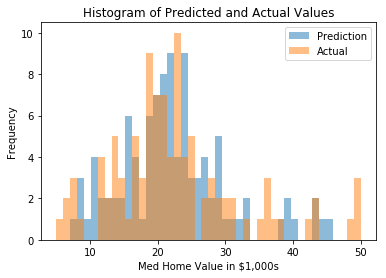

In [28]:
bins = np.linspace(5, 50, 45)

plt.hist(predictions, bins, alpha=0.5, label='Prediction')
plt.hist(y_batch, bins, alpha=0.5, label='Actual')
plt.title('Histogram of Predicted and Actual Values')
plt.xlabel('Med Home Value in $1,000s')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

In [37]:
len(x_vals_test)

101

In [36]:
batch_size

101

In [38]:
help(tf.squeeze)

Help on function squeeze in module tensorflow.python.ops.array_ops:

squeeze(input, axis=None, name=None, squeeze_dims=None)
    Removes dimensions of size 1 from the shape of a tensor.
    
    Given a tensor `input`, this operation returns a tensor of the same type with
    all dimensions of size 1 removed. If you don't want to remove all size 1
    dimensions, you can remove specific size 1 dimensions by specifying
    `axis`.
    
    For example:
    
    ```prettyprint
    # 't' is a tensor of shape [1, 2, 1, 3, 1, 1]
    shape(squeeze(t)) ==> [2, 3]
              ```
    
    Or, to remove specific size 1 dimensions:
    
    ```prettyprint
    # 't' is a tensor of shape [1, 2, 1, 3, 1, 1]
    shape(squeeze(t, [2, 4])) ==> [1, 2, 3, 1]
    ```
    
    Args:
      input: A `Tensor`. The `input` to squeeze.
      axis: An optional list of `ints`. Defaults to `[]`.
        If specified, only squeezes the dimensions listed. The dimension
        index starts at 0. It is an error to

In [39]:
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.examples.tutorials.mnist import input_data

In [40]:
sess = tf.Session()
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [41]:
train_size = 1000
test_size = 102
rand_train_indices = np.random.choice(len(mnist.train.images), train_size, replace=False)
rand_test_indices = np.random.choice(len(mnist.test.images), test_size, replace=False)
x_vals_train = mnist.train.images[rand_train_indices]
x_vals_test = mnist.test.images[rand_test_indices]
y_vals_train = mnist.train.labels[rand_train_indices]
y_vals_test = mnist.test.labels[rand_test_indices]

In [42]:
k = 4
batch_size=6

In [43]:
x_data_train = tf.placeholder(shape=[None, 784], dtype=tf.float32)
x_data_test = tf.placeholder(shape=[None, 784], dtype=tf.float32)
y_target_train = tf.placeholder(shape=[None, 10], dtype=tf.float32)
y_target_test = tf.placeholder(shape=[None, 10], dtype=tf.float32)

In [44]:
distance = tf.reduce_sum(tf.abs(tf.sub(x_data_train, tf.expand_dims(x_data_test,1))), reduction_indices=2)

In [45]:

top_k_xvals, top_k_indices = tf.nn.top_k(tf.neg(distance), k=k)

prediction_indices = tf.gather(y_target_train, top_k_indices)
count_of_predictions = tf.reduce_sum(prediction_indices, reduction_indices=1)

prediction = tf.argmax(count_of_predictions, dimension=1)

In [47]:
num_loops = int(np.ceil(len(x_vals_test)/batch_size))
test_output = []
actual_vals = []
for i in range(num_loops):
    min_index = i*batch_size
    max_index = min((i+1)*batch_size,len(x_vals_train))
    x_batch = x_vals_test[min_index:max_index]
    y_batch = y_vals_test[min_index:max_index]
    predictions = sess.run(prediction, feed_dict={x_data_train: x_vals_train, x_data_test: x_batch,
                                         y_target_train: y_vals_train, y_target_test: y_batch})
    test_output.extend(predictions)
    actual_vals.extend(np.argmax(y_batch, axis=1))

In [49]:
accuracy = sum([1./test_size for i in range(test_size) if test_output[i]==actual_vals[i]])
print('Accuracy on test set: ' + str(accuracy))

Accuracy on test set: 0.9019607843137244


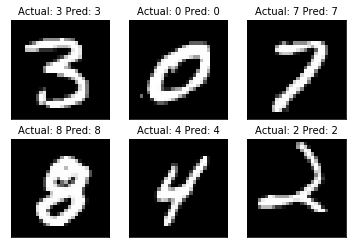

In [52]:
actuals = np.argmax(y_batch, axis=1)
Nrows = 2
Ncols = 3
for i in range(len(actuals)):
    plt.subplot(Nrows, Ncols, i+1)
    plt.imshow(np.reshape(x_batch[i], [28,28]), cmap='Greys_r')
    plt.title('Actual: ' + str(actuals[i]) + ' Pred: ' + str(predictions[i]), fontsize=10)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)